# setup

In [1]:
import os
os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')

# imports

In [2]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import pickle

# relative imports
from core import models, distributions, datasets, utils, metrics, training

/Users/martinmarek/miniforge3/envs/py39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

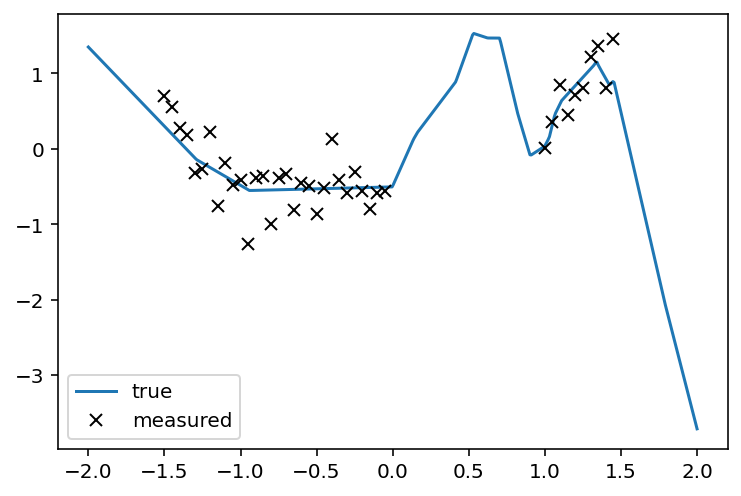

In [4]:
(x_true, y_true), (x_train, y_train), (x_test, y_test) = datasets.load_1d_regression_dataset()
fig, ax = plt.subplots()
ax.plot(x_true[:, 0], y_true, label='true')
# ax.plot(x_test[:, 0], y_test, 'x', c='black', label='measured')
ax.plot(x_train[:, 0], y_train, 'x', c='black', label='measured')
ax.legend()
plt.show()

# model

In [5]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 1*[50]
init_sd = 0.1
prior_sd = 1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
params_init = jax.tree_map(lambda x: x.astype(jnp.float32), params_init)
n_params = len(utils.ravel_pytree_(params_init))
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [6]:
# test model
print('num. params: ', n_params)
print('params: ', jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

num. params:  202
params:  FlatMap({
  'linear': FlatMap({'b': (50,), 'w': (1, 50)}),
  'linear_1': FlatMap({'b': (2,), 'w': (50, 2)}),
})
PDF test:  -288.9542 -929.3367 -1218.2909


# training

In [7]:
# create multiple chains using each method to allow cmputing r_hat
n_chains = 3

# number of samples to keep from each chain
n_samples = 200

# define functions to map params as pytrees <-> arrays
unravel_fn = ravel_pytree(params_init)[1]

## SGD

In [8]:
%%time
sgd_n_epochs = 10_000
sgd_ll_start = 1e-3
sgd_ll_stop = 1e-5
key = jax.random.PRNGKey(0)
chains_sgd, sgd_loss = training.create_sgd_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, n_chains)

CPU times: user 1.42 s, sys: 27.8 ms, total: 1.45 s
Wall time: 1.45 s


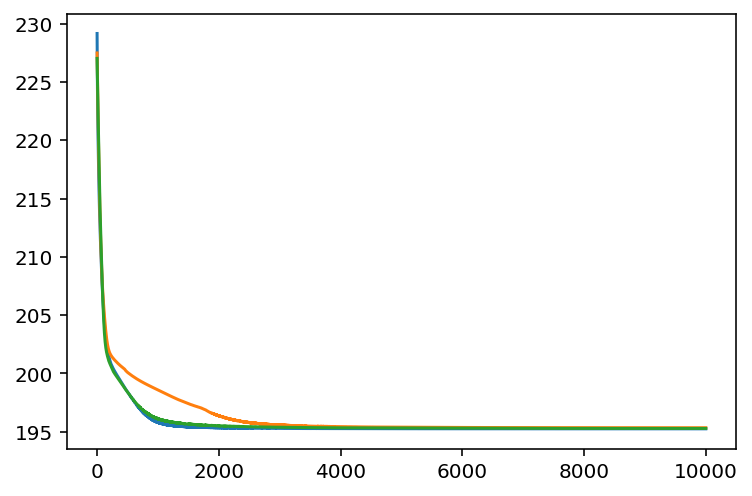

In [9]:
fig, ax = plt.subplots()
for i in range(n_chains):
    ax.plot(sgd_loss[i], alpha=1)
plt.show()

## RWMH

In [10]:
%%time
step_size = 1e-2
n_blind_steps = 10_000
key = jax.random.PRNGKey(0)
chains_rwmh, avg_accept_prob = training.create_rwmh_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_blind_steps, n_chains, n_samples)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 33.14%
CPU times: user 28.7 s, sys: 246 ms, total: 28.9 s
Wall time: 28.7 s


## HMC

In [11]:
%%time
step_size = 1e-3
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
chains_hmc, avg_accept_prob = training.create_hmc_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_leapfrog_steps, n_chains, n_samples)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 91.92%
CPU times: user 1min 7s, sys: 228 ms, total: 1min 8s
Wall time: 1min 8s


## ensamble

In [26]:
%%time
key = jax.random.PRNGKey(0)
chains_ensamble = training.create_sgd_ensambles(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, n_chains, n_samples)

CPU times: user 3min 38s, sys: 2.51 s, total: 3min 41s
Wall time: 2min 43s


## numpyro

In [12]:
# %%time
# potential_fn = lambda x: -log_posterior_fn(x)
# nuts_kernel = NUTS(potential_fn=potential_fn)
# mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=n_samples)
# chains_numpyro = []
# for i in range(n_chains):
#     key, init_key, mcmc_key = jax.random.split(key, 3)
#     params_start = utils.normal_like_tree(params_init, init_key)
#     params_start = jax.tree_map(lambda x: init_sd*x, params_start)
#     mcmc.run(mcmc_key, init_params=params_start)
#     chain = mcmc.get_samples()
#     chains_numpyro += [chain]
#     # TODO: numpyro seems to return just the last node, not the full history
#     print(len(chain))

## mixed training

In [13]:
%%time
n_outer_steps = 5
n_inner_steps = n_samples // n_outer_steps
key = jax.random.PRNGKey(0)
chains_mixed, avg_accept_prob = training.create_mixed_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_leapfrog_steps, n_chains, n_outer_steps, n_inner_steps)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 92.53%
CPU times: user 1min 14s, sys: 312 ms, total: 1min 15s
Wall time: 1min 15s


## save training output

In [27]:
chains_dict = {
    'sgd': chains_sgd,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'mixed': chains_mixed,
    'ensamble': chains_ensamble,
}

# predictions

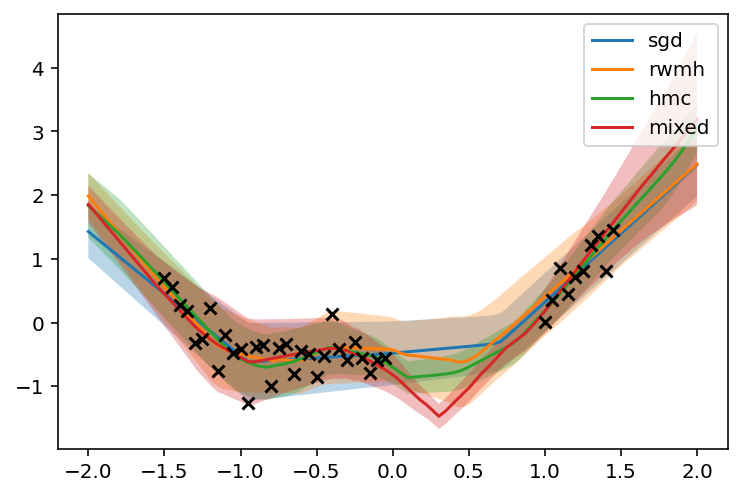

In [15]:
fig, ax = plt.subplots()

# plot training data
ax.scatter(x_train[:, 0], y_train, marker='x', c='black', zorder=10)

# plot predictions
x_full = jnp.linspace(-2, 2, 100)[:, None]
for i, (name, chains) in enumerate(chains_dict.items()):
    y_hat = predict_fn(x_full, unravel_fn(chains[0, 0]))
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=name)

ax.legend(loc='upper right')
plt.show()

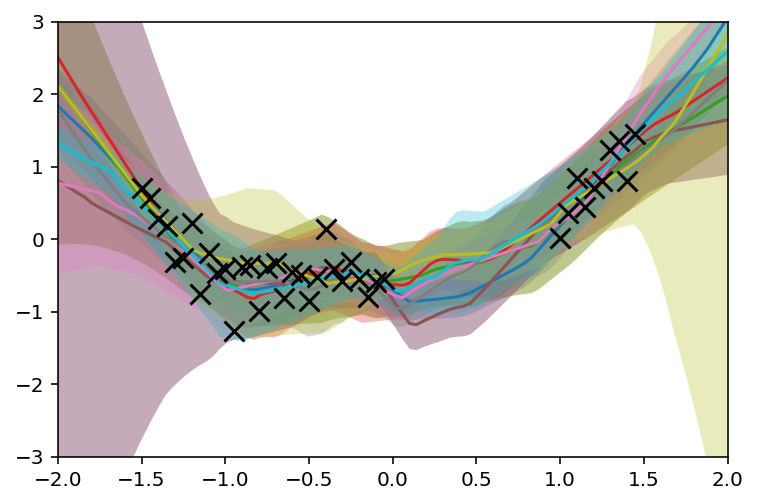

In [29]:
fig, ax = plt.subplots()

# plot predictions
chain = chains_dict['hmc'].reshape([-1, n_params])
x_full = jnp.linspace(-2, 2, 100)[:, None]
for i, params in enumerate(chain[:10]):
    y_hat = predict_fn(x_full, unravel_fn(params))
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=i)

# plot training data
ax.scatter(x_train[:, 0], y_train, marker='x', c='black', s=100, zorder=10)
ax.set_xlim([-2, 2])
ax.set_ylim([-3, 3])

# ax.legend()
plt.show()

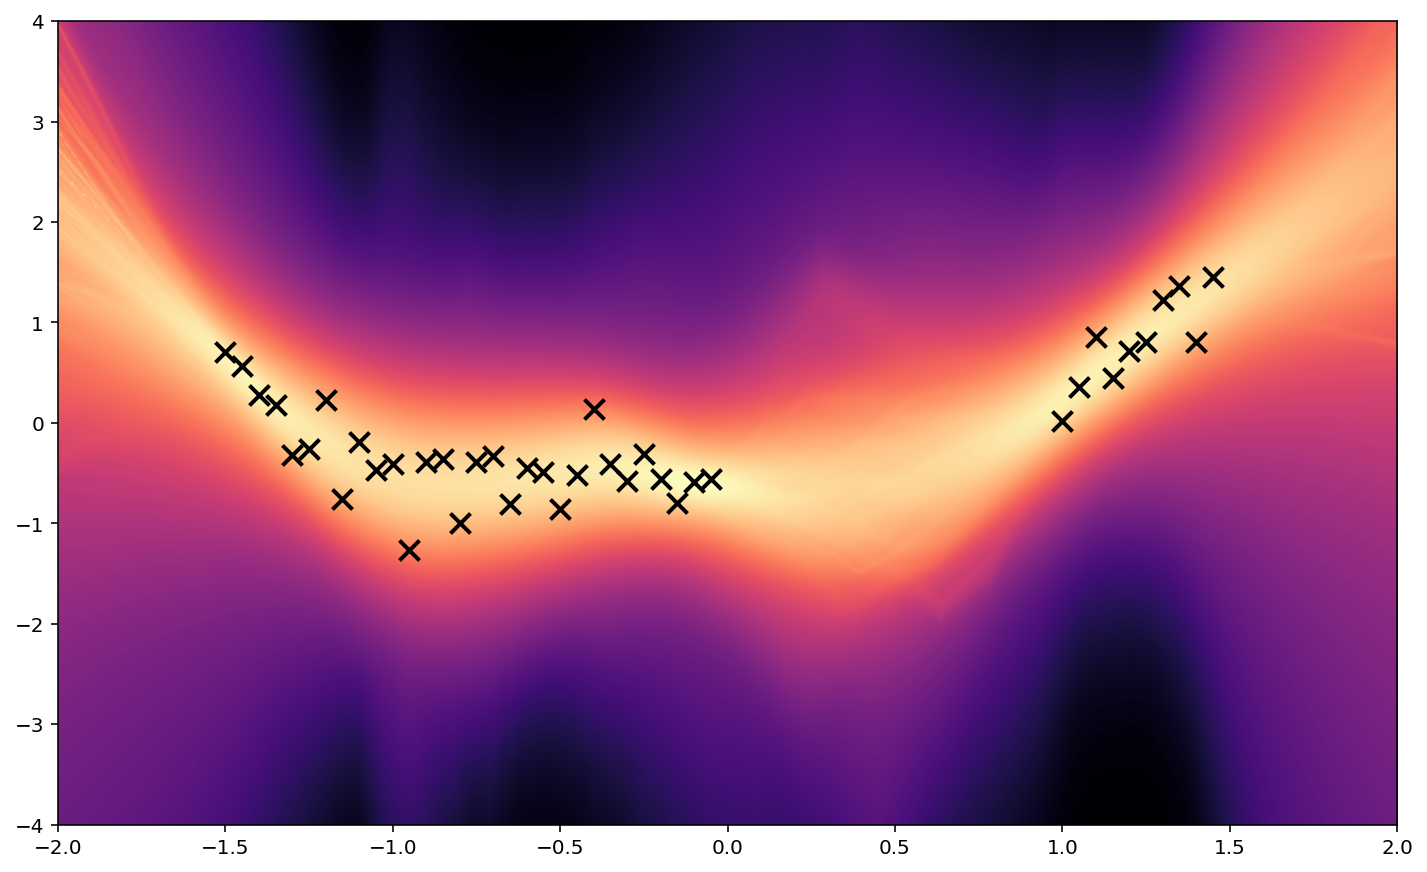

In [17]:
# load chain
chains = chains_dict['hmc']
chain = chains.reshape([-1, n_params])

# create grid to evaluate posterior predictive density
nx, ny = 800, 400
x_full = jnp.linspace(-2, 2, nx)
y_full = jnp.linspace(-4, 4, ny)

def get_posterior_density(params):
    params = unravel_fn(params)
    y_hat = predict_fn(x_full[:, None], params)
    mean, std = y_hat[:, 0], y_hat[:, 1]
    log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
    log_prob = jnp.nan_to_num(log_prob)
    return log_prob
    # z_full = z_full.at[:, :, i].set(log_prob)
    
density_fn_vmap = jax.vmap(get_posterior_density)
z_full = density_fn_vmap(chain)
    
# average over posterior samples
# - p(y) = sum (p(y|theta_i) * p(theta_i)) = (sum p(y|theta_i)) / n
# - p(y) = (sum exp logp(y|theta_i)) / n
# - logp(y) = log((sum exp logp(y|theta_i)) / n)
# - logp(y) = (log-sum-exp logp(y|theta_i)) - log(n)
log_z_full = jax.scipy.special.logsumexp(z_full, 0) - jnp.log(len(chain))
z_full = jnp.exp(log_z_full)

# density plot
fig, ax = plt.subplots(figsize=[12, 8])
extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
ax.imshow(z_full.T**(1/8), origin='lower', cmap='magma', extent=extent, aspect=0.3, label='predicted')
# ax.plot(x_true[:, 0], y_true, label='true', lw=4, c='green')
ax.scatter(x_train[:, 0], y_train, marker='x', color='black', s=100, linewidth=2, label='observed')
# ax.scatter(x_test[:, 0], y_test, marker='x', color='grey', s=100, linewidth=2, label='observed')
# ax.legend()
plt.show()

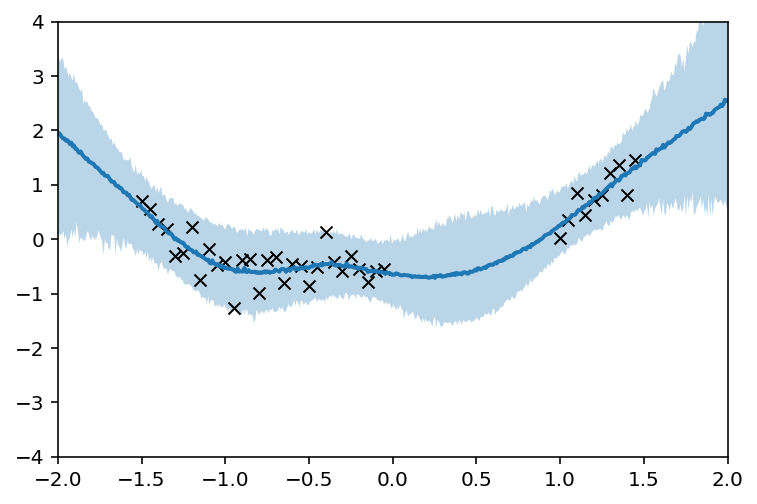

In [18]:
chains = chains_dict['hmc']
chain = chains.reshape([-1, n_params])
key = jax.random.PRNGKey(0)
alpha = 0.05
n_steps = len(chain)
nx = 500
x_full = jnp.linspace(-2, 2, nx)
n_samples = 1_000
n_samples_per_step = n_samples // len(chain)

samples = jnp.zeros([nx, len(chain), n_samples_per_step])
for i, params in enumerate(chain):
    key, _ = jax.random.split(key)
    y_hat = predict_fn(x_full[:, None], unravel_fn(params))
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    current_samples = mean[:, None] + std[:, None] * jax.random.normal(key, [nx, n_samples_per_step])
    samples = samples.at[:, i, :].set(current_samples)

# flatten sampled predictions across posterior samples
samples = samples.reshape([nx, -1])

# get posterior predictive quntiles
quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    
# CI plot
fig, ax = plt.subplots()
ax.fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3)
ax.plot(x_full, quantiles[1, :], label='predicted', lw=2)
# ax.plot(x_true[:, 0], y_true, label='true', c='red')
ax.scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, label='observed')
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.legend()
plt.show()

# diagnostics

## history of a single parameter

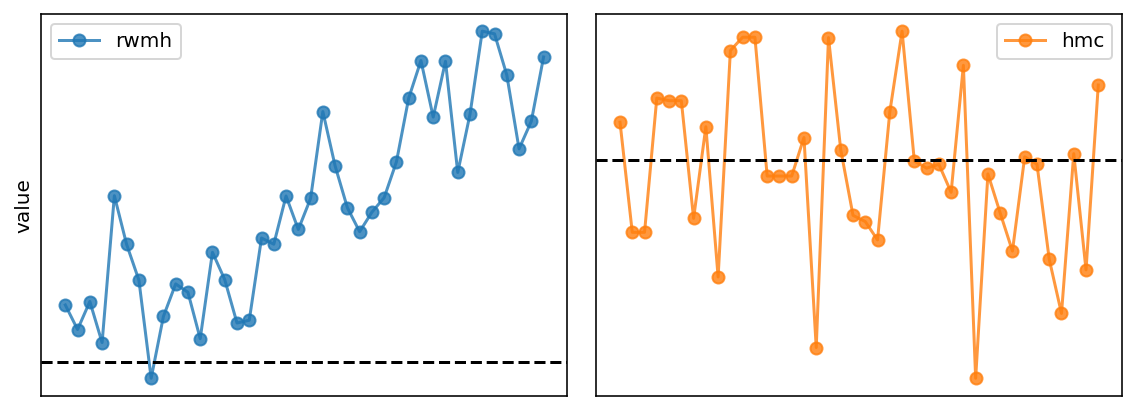

In [19]:
chain_idx = 0
param_idx = 0
n_points = 40
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    param = chains[chain_idx, :, param_idx]
    line, = axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    axs[i].axhline(y=chains[:, :, param_idx].mean(), linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
    if i in [2, 3]: axs[i].set_xlabel('step')
    if i in [0, 2]: axs[i].set_ylabel('value')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

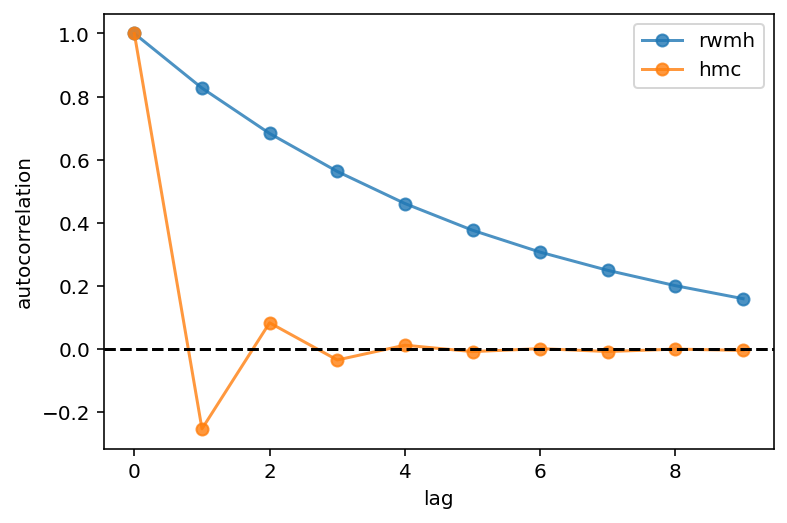

In [20]:
fig, ax = plt.subplots()

# autocorrelation
f = lambda x: x
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, f, 10)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

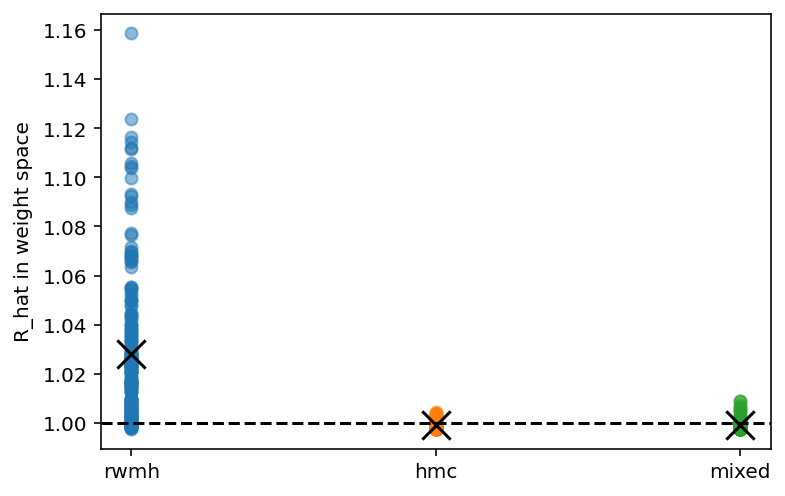

In [21]:
fig, ax = plt.subplots()

# R_hat
f = lambda x: x
chains_to_show = ['rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.r_hat(chains, f)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
# ax.set_ylim([0.99, 1.16])
plt.show()

## Likelihood of test data

In [22]:
# function like 'predict_fn' but takes in an array an unravels it
def predict_from_array(x, params_flat):
    params_tree = unravel_fn(params_flat)
    y_hat = predict_fn(x, params_tree)
    return y_hat


def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    predict_vmap = jax.vmap(predict_from_array, [None, 0])
    y_hat = predict_vmap(x_test, chain)
    mean, std = y_hat[:, :, 0], y_hat[:, :, 1]

    # compute likelihood for each node in the chain
    log_likelihood = distributions.gaussian_log_pdf(y_test[None, :], mean, std)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood


for i, (name, chains) in enumerate(chains_dict.items()):    
    ll = jax.vmap(chain_to_loglike)(chains)
    print(f'{name}: {ll.mean():.3f} ± {ll.std():.4f}')

sgd: -2096.266 ± 94.9333
rwmh: -191.731 ± 11.4744
hmc: -195.160 ± 3.2189
mixed: -209.274 ± 5.2961


## Distribution of parameters

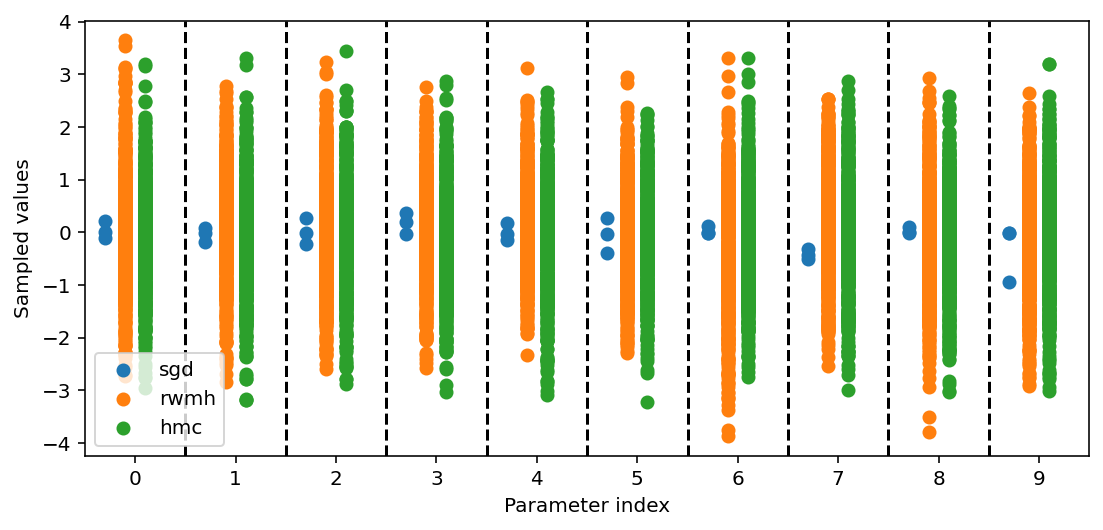

In [23]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()